In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
from neural_process import NeuralProcess

from load_data import *
from utils import *
from vae import *
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
# from training import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
movie_features = load__movies_info()
user_features = load_users_info()
user_movie_ratings = load_user_movie_rating()
avg_score = user_movie_ratings.groupby("movie id").mean()['rating'].sort_values(ascending=False)
movie_features=pd.merge(movie_features,avg_score,on="movie id")

In [55]:
movies = postprocess_movie(movie_features)
users  = postprocess_user(user_features)

In [56]:
U_Mat = utility_matrix(user_movie_ratings)

In [57]:
class UserMovieTrainDataset(Dataset):
    def __init__(self, U_matrix, users, movies):
        self.U_matrix = np.nan_to_num(U_matrix.to_numpy())
        self.users = users
        self.movies = movies
        
    def __len__(self):
        return self.U_matrix.shape[0] - 50
    
    def __getitem__(self, idx):
        
        user_ratings = self.U_matrix[idx]
        user_ratings_valid_idx = np.nonzero(user_ratings)
        rated_movies = movies[user_ratings_valid_idx] # n x 20
        
        user = self.users[idx]
        user = np.repeat(user[np.newaxis,...], rated_movies.shape[0], axis=0) # n x 3
        
        features = np.concatenate([rated_movies, user], axis=1)
        ratings = user_ratings[user_ratings_valid_idx].reshape(-1, 1)
        
        return torch.from_numpy(features).float(), torch.from_numpy(ratings).float()

class UserMovieTestDataset(Dataset):
    def __init__(self, U_matrix, users, movies):
        self.U_matrix = np.nan_to_num(U_matrix.to_numpy())
        self.users = users
        self.movies = movies
        
    def __len__(self):
        return 50
    
    def __getitem__(self, idx):
        
        user_ratings = self.U_matrix[-idx]
        user_ratings_valid_idx = np.nonzero(user_ratings)
        rated_movies = movies[user_ratings_valid_idx] # n x 20
        
        user = self.users[idx]
        user = np.repeat(user[np.newaxis,...], rated_movies.shape[0], axis=0) # n x 3
        
        features = np.concatenate([rated_movies, user], axis=1)
        ratings = user_ratings[user_ratings_valid_idx].reshape(-1, 1)
        
        return torch.from_numpy(features).float(), torch.from_numpy(ratings).float()

In [58]:
training_dataset = UserMovieTrainDataset(U_Mat, users, movies)
testing_dataset = UserMovieTestDataset(U_Mat, users, movies)
len(dataset)

893

In [93]:
x_dim = 23
y_dim = 1
r_dim = 100  # Dimension of representation of context points
z_dim = 100  # Dimension of sampled latent variable
h_dim = 100  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

In [94]:
# pretraining
batch_size = 1
num_context = 10
num_target = 20

training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_dataloader = DataLoader(testing_dataset, batch_size=1)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=5e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(training_dataloader, 30)

iteration 200, loss 72.613
iteration 400, loss 55.670
iteration 600, loss 62.999
iteration 800, loss 44.281
Epoch: 0, Avg_loss: 50.35495031427296
iteration 1000, loss 37.780
iteration 1200, loss 43.639
iteration 1400, loss 52.746
iteration 1600, loss 45.402
Epoch: 1, Avg_loss: 43.60615925505874
iteration 1800, loss 49.395
iteration 2000, loss 35.150
iteration 2200, loss 43.976
iteration 2400, loss 45.242
iteration 2600, loss 37.641
Epoch: 2, Avg_loss: 42.25991039126611
iteration 2800, loss 42.284
iteration 3000, loss 43.995
iteration 3200, loss 47.573
iteration 3400, loss 42.703
Epoch: 3, Avg_loss: 42.19203075823298
iteration 3600, loss 38.888
iteration 3800, loss 45.622
iteration 4000, loss 42.864
iteration 4200, loss 38.242
iteration 4400, loss 51.764
Epoch: 4, Avg_loss: 41.72935864746504
iteration 4600, loss 39.167
iteration 4800, loss 53.871
iteration 5000, loss 35.988
iteration 5200, loss 40.180
Epoch: 5, Avg_loss: 41.794605951426675
iteration 5400, loss 26.185
iteration 5600, los

In [99]:
#refining
batch_size = 1

training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=5e-5)
np_trainer = MovieNPTrainer(device, neuralprocess, optimizer)

neuralprocess.training = True
np_trainer.train(training_dataloader, 10)

iteration 100, loss 47.981
iteration 200, loss 30.383
iteration 300, loss 47.898
iteration 400, loss 43.644
iteration 500, loss 85.883
iteration 600, loss 72.742
no safe initialization possible
iteration 700, loss 83.982
iteration 800, loss 40.947
Epoch: 0, Avg_loss: 56.15898701538564
iteration 900, loss 64.330
iteration 1000, loss 42.431
no safe initialization possible
iteration 1100, loss 62.505
iteration 1200, loss 60.104
iteration 1300, loss 59.788
iteration 1400, loss 60.364
iteration 1500, loss 57.171
iteration 1600, loss 63.390
iteration 1700, loss 24.639
Epoch: 1, Avg_loss: 56.06179232880356
iteration 1800, loss 23.130
iteration 1900, loss 38.283
no safe initialization possible
iteration 2000, loss 46.610
iteration 2100, loss 53.675
iteration 2200, loss 67.460
iteration 2300, loss 40.674
iteration 2400, loss 48.447
iteration 2500, loss 49.444
iteration 2600, loss 51.782
Epoch: 2, Avg_loss: 56.15247425707297
iteration 2700, loss 58.619
iteration 2800, loss 45.821
iteration 2900,

In [37]:
def context_rest_split(x, y, num_context):
    num_points = x.shape[1]

    # Sample locations of context and target points
    indices = [i for i in range(num_points)]
    locations = sorted(random.sample(indices,num_context))
    rest_locations = sorted([i for i in indices if i not in locations])

    x_context = x[:, locations, :]
    y_context = y[:, locations, :]
    x_rest = x[:, rest_locations, :]
    y_rest = y[:, rest_locations, :]

    return x_context, y_context, locations, x_rest, y_rest, rest_locations

In [38]:
x, y = testing_dataset[3]
x_context, y_context, locations, x_rest, y_rest, rest_locations = context_rest_split(x.unsqueeze(0), y.unsqueeze(0), 5)
x.shape

torch.Size([22, 23])

In [39]:
neuralprocess.training = False
for i in range(64):
    p_y_pred = neuralprocess(x_context, y_context, x_rest)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    sigma = p_y_pred.scale.detach()
    break

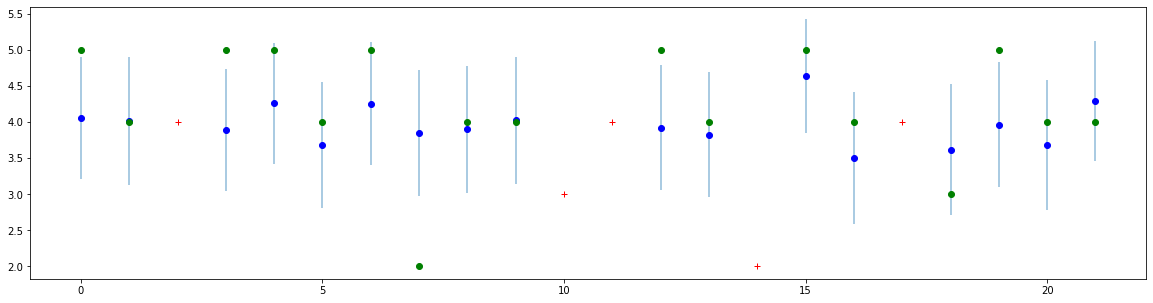

In [40]:
plt.rcParams['figure.figsize'] = 20, 5

mu = mu.numpy().squeeze()
sigma = sigma.numpy().squeeze()
plt.plot(locations, y_context.numpy().squeeze(), 'r+')
plt.plot(rest_locations, mu, 'bo')
plt.plot(rest_locations, y_rest.numpy().squeeze(), 'go')
for i, idx in enumerate(rest_locations):
    plt.vlines(idx, ymin=mu[i] - sigma[i], ymax=mu[i] + sigma[i], alpha=0.5)

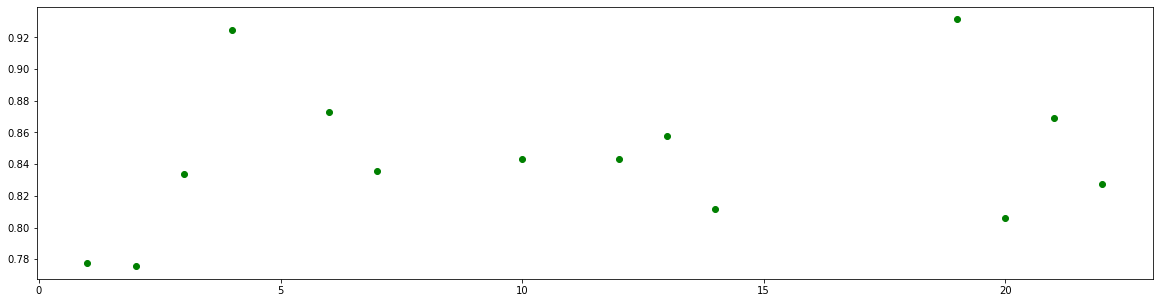

In [210]:
plt.plot(rest_locations, sigma, 'go')

In [197]:
rest_locations

[0, 3, 4, 5, 7, 8, 9, 10, 13, 16, 17, 20, 21, 23]

In [41]:
def safeopt_np(np_model, moive_user_features, ratings, beta=2, threshold=3.0, num_init_samples=5):
    '''
    np_model: a trained neural process model
    movie_user_features: a user and its movies concatenated together (20+3) x num_movies
    beta: a constant used for computing Q set
    threshold: safety threshold
    num_init_samples: initial context points
    '''
    # get initial context points
    x_context, y_context, locations, x_rest, y_rest, rest_locations = context_rest_split(moive_user_features, ratings, num_context)
    with torch.no_grad():
        p_y_pred = neuralprocess(x_context, y_context, x_rest)
        mu = mu.numpy().squeeze()
        sigma = sigma.numpy().squeeze()
        
        # compute Qt
        Q_t = np.zeros(2, mu.shape[0])
        Q_t[0, :] = mu - beta * sigma
        Q_t[1, :] = mu + beta * sigma
        
        l, u = Q_t[0], Q_t[1]
        w = u - l
        
        # compute St
        S_t = l > threshold
        
        M_t = np.empty(S_t.shape[0])
        M_t[:] = False
        M_t[S_t] = u[S_t] >= np.max(l[S_t])
        
        